In [76]:
from qiskit_optimization.applications import Maxcut, Tsp
import matplotlib.pyplot as plt
import networkx as nx
import pennylane as qml
from pennylane import numpy as np
from pennylane import qaoa
from functools import partial

In [77]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

Cost Hamiltonian
  (0.0) [Z0]
+ (0.0) [Z1]
+ (0.0) [Z3]
+ (0.0) [Z4]
+ (0.6931471805599453) [Z2]
+ (0.6931471805599453) [Z5]
Mixer Hamiltonian
  (-0.25) [X0 Y1 Y5]
+ (-0.25) [X1 Y0 Y3]
+ (-0.25) [X2 Y3 Y4]
+ (-0.25) [X3 Y2 Y1]
+ (-0.25) [X4 Y5 Y2]
+ (-0.25) [X5 Y4 Y0]
+ (0.25) [X0 X1 X5]
+ (0.25) [Y0 Y1 X5]
+ (0.25) [Y0 X1 Y5]
+ (0.25) [X1 X0 X3]
+ (0.25) [Y1 Y0 X3]
+ (0.25) [Y1 X0 Y3]
+ (0.25) [X2 X3 X4]
+ (0.25) [Y2 Y3 X4]
+ (0.25) [Y2 X3 Y4]
+ (0.25) [X3 X2 X1]
+ (0.25) [Y3 Y2 X1]
+ (0.25) [Y3 X2 Y1]
+ (0.25) [X4 X5 X2]
+ (0.25) [Y4 Y5 X2]
+ (0.25) [Y4 X5 Y2]
+ (0.25) [X5 X4 X0]
+ (0.25) [Y5 Y4 X0]
+ (0.25) [Y5 X4 Y0]
Mapping
{0: (0, 1), 1: (0, 2), 2: (1, 0), 3: (1, 2), 4: (2, 0), 5: (2, 1)}


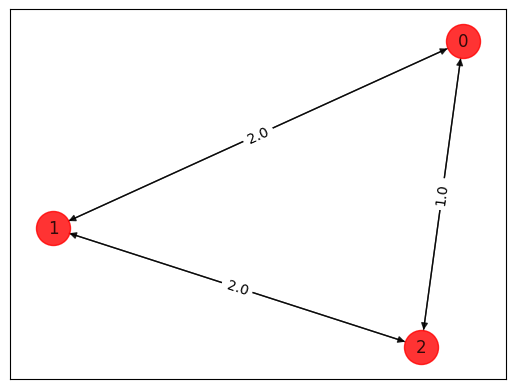

In [78]:
# Generating a graph of 3 nodes
n_nodes = 3
a = np.random.random((n_nodes, n_nodes))*2
np.fill_diagonal(a, 0)
a = np.ceil(a)
np.fill_diagonal(a, 0)

g = nx.DiGraph(a) 
cost, mixer, mapping = qml.qaoa.max_weight_cycle(g)

draw_graph(g, "r", nx.spring_layout(g))

print("Cost Hamiltonian")
print(cost)
print("Mixer Hamiltonian")
print(mixer)
print("Mapping")
print(mapping)

6
Cost after step 1: 0.21630437871792713
Cost after step 2: 0.20657414120015757
Cost after step 3: 0.19700336576414998
Cost after step 4: 0.18760928558033968
Cost after step 5: 0.17840648969176476
Cost after step 6: 0.1694070175013539
Cost after step 7: 0.16062049151143978
Cost after step 8: 0.15205427854495326
Cost after step 9: 0.14371367038906818
Cost after step 10: 0.1356020757992974
Optimal Parameters
[[0.53111695 0.44042486]
 [0.51020406 0.56674588]]


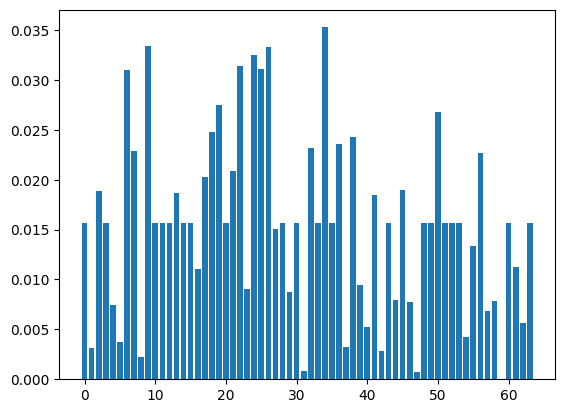

In [79]:

def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost)
    qaoa.mixer_layer(alpha, mixer)

# 3= 6
# 4 = 12
num_qubits = n_nodes*(n_nodes-1) 
print(num_qubits)
wires = range(num_qubits)
depth = 2

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

dev = qml.device("default.qubit", wires=wires)

#@partial(qml.cut_circuit, auto_cutter=True) 
@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost)

optimizer = qml.GradientDescentOptimizer()
steps = 10
params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

for i in range(steps):
    params = optimizer.step(cost_function, params)
    print(f"Cost after step {i + 1}: {cost_function(params)}")

print("Optimal Parameters")
print(params)


@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)

probs = probability_circuit(params[0], params[1])

# bitstrings
bitstrings = [format(i, "0" + str(len(wires)) + "b") for i in range(2 ** len(wires))]

plt.bar(range(2**len(wires)), probs)
plt.show()

{0: (0, 1), 1: (0, 2), 2: (1, 0), 3: (1, 2), 4: (2, 0), 5: (2, 1)}
Most likely bitstrings
100010 with probability 0.03527704047676675
001001 with probability 0.03336045977999149
011010 with probability 0.03327366628262618
011000 with probability 0.032500983112754823
010110 with probability 0.031444615188331734
011001 with probability 0.031068664036874145
000110 with probability 0.0310152114849038
010011 with probability 0.02744298466845304
110010 with probability 0.026761984904133465
Less likely bitstrings
111011 with probability 3.608564562130337e-05
101111 with probability 0.0007453870383353578
011111 with probability 0.0008214922215223555
001000 with probability 0.002250118676545964
101010 with probability 0.0028276091605434917
000001 with probability 0.003143823409628797
100101 with probability 0.0032707301924586926
000101 with probability 0.0037443199158599073
110110 with probability 0.00428149202580217
101000 with probability 0.005271966360623097
100010


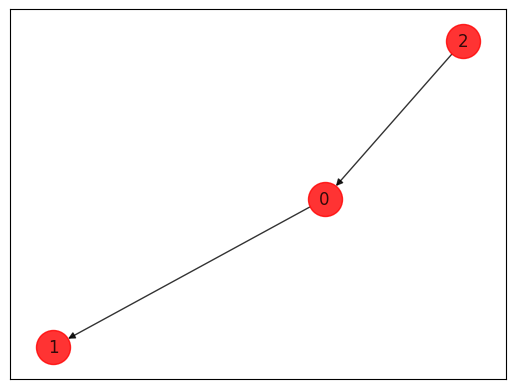

In [80]:
print(mapping)

# get most likely bitstring (5 most likely)
most_likely = np.argsort(probs)[:-10:-1]

most_likely_top = ''

print("Most likely bitstrings")
for i in most_likely:
    print(bitstrings[i], "with probability", probs[i])
    


less_likely = np.argsort(probs)[:10]
print("Less likely bitstrings")
for i in less_likely:
    print(bitstrings[i], "with probability", probs[i])
    pass

most_likely_top = bitstrings[most_likely[0]]

all_path = []


print(most_likely_top)

for i in range(len(mapping)):
    #print(most_likely_top[i])
    if most_likely_top[i] == "1":
        all_path.append(mapping[i])

G = nx.DiGraph()
G.add_edges_from(all_path)
draw_graph(G, "r", nx.spring_layout(G))
plt.show()